In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn.functional as F

In [3]:
words = open('names.txt', 'r').read().split('\n')
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
charset = sorted(list(set(''.join(words))))
charset

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [5]:
stoi = {s:i+1 for i, s in enumerate(charset)}
stoi['.'] = 0

In [6]:
itos = {i:s for s, i in stoi.items()}

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
g = torch.Generator().manual_seed(2525) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [9]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [10]:
for p in parameters:
    p.requires_grad = True

In [11]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [12]:
lri = []
lossi = []
steps = []

In [13]:
for i in range(32000):

    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (48,))

    # forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    print(loss.item())  

    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = -0.01 if i < 10000 else -0.01
    for p in parameters:
        p.data += lr * p.grad

    lri.append(lr)
    lossi.append(loss.log10().item())
    steps.append(i)
   

25.85179328918457
27.29681396484375
25.14850425720215
22.15612030029297
22.61724090576172
23.542497634887695
28.231664657592773
22.562820434570312
26.099241256713867
22.20203971862793
22.680402755737305
25.683908462524414
21.874441146850586
22.7086181640625
27.249914169311523
23.529191970825195
21.852500915527344
21.070158004760742
20.42072105407715
22.45537567138672
21.68227195739746
24.028541564941406
25.874757766723633
21.678537368774414
22.38775062561035
24.02777862548828
21.23356819152832
24.671831130981445
21.423263549804688
19.959272384643555
21.773141860961914
21.087251663208008
20.926424026489258
24.257505416870117
21.825027465820312
19.502870559692383
22.511878967285156
20.25839614868164
20.025739669799805
18.295494079589844
20.904098510742188
22.114187240600586
19.43926429748535
18.2157039642334
17.709386825561523
19.494243621826172
20.232397079467773
20.408456802368164
20.41330337524414
18.726045608520508
14.053177833557129
15.399575233459473
18.627012252807617
21.658546447

11.86004638671875
11.881155967712402
11.041075706481934
11.157962799072266
11.195660591125488
12.724898338317871
10.446255683898926
10.339461326599121
11.74988079071045
10.36055850982666
9.259323120117188
9.945664405822754
10.303145408630371
11.580330848693848
11.672542572021484
9.348739624023438
11.068293571472168
12.318096160888672
10.860875129699707
11.397919654846191
12.116665840148926
8.394791603088379
10.7554931640625
13.30505657196045
12.300984382629395
11.869178771972656
11.248573303222656
9.399352073669434
10.729148864746094
9.776036262512207
11.700465202331543
10.13371753692627
10.962233543395996
12.47551441192627
10.834349632263184
7.838146209716797
11.630630493164062
11.917658805847168
12.571606636047363
12.122618675231934
12.666182518005371
8.221439361572266
8.80384349822998
11.396804809570312
10.514158248901367
11.046692848205566
9.599343299865723
9.355798721313477
10.388286590576172
11.624835968017578
12.03586483001709
9.752484321594238
9.132772445678711
9.19428253173828

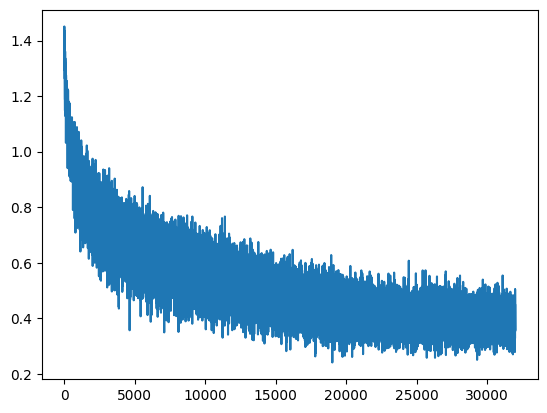

In [14]:
plt.plot(steps, lossi)

In [15]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.4570, grad_fn=<NllLossBackward0>)

In [16]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4721, grad_fn=<NllLossBackward0>)

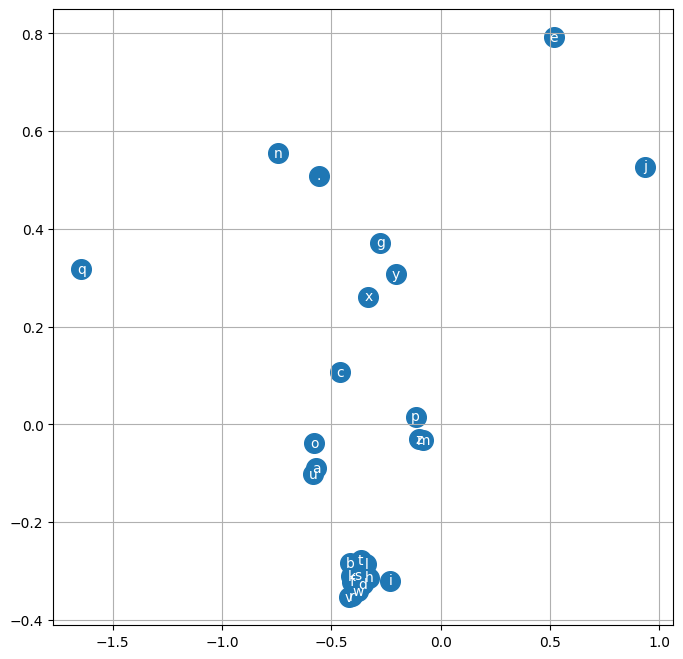

In [17]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [18]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [19]:
# sample from the model
g = torch.Generator().manual_seed(2525 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

sacelle.
luad.
srionhro.
makel.
naym.
onna.
bina.
mengsenni.
slia.
amarre.
cula.
azpy.
solena.
ely.
gaih.
dhquell.
abonianiahir.
abina.
alerues.
liod.
